In [1]:
# Import libraries
import pandas as pd
import glob 
import numpy as np
import matplotlib.pyplot as plt
import os
import skgstat as skg
from skgstat import models
import gstatsim as gs
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import QuantileTransformer 
import pyproj # for reprojection

In [2]:
# Fields paths
field_a_paths = glob.glob("D:/Cours bioingé/BIR M2/Mémoire/Data/Drone GPR/Field A/*.txt") # return all file paths that match a specific pattern
field_b_paths = glob.glob("D:/Cours bioingé/BIR M2/Mémoire/Data/Drone GPR/Field B/*.txt")

In [3]:
sample_number = 0           # [0-10]
field_path = field_a_paths  # field_a_paths or field_b_paths

In [4]:
# Define the transformer for WGS84 to UTM (UTM zone 32N)
transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:32632", always_xy=True)

In [5]:
# Import data function
gpr_data_tables = []
def import_data(file_paths=glob.glob("D:/Cours bioingé/BIR M2/Mémoire/Data/Drone GPR/Field A/*.txt")):
    gpr_data_tables = []
    for file_path in file_paths:
        data_frame = pd.read_csv(file_path, sep = "  ", engine="python") # read csv file
        data_frame.columns = ['y', 'x', 'vwc'] # rename columns
        gpr_data_tables.append(data_frame)

    return gpr_data_tables

# Extract dates function
dates = []
def extract_dates(file_paths=glob.glob("D:/Cours bioingé/BIR M2/Mémoire/Data/Drone GPR/Field A/*.txt")):
    for file_path in file_paths:
        file_name = os.path.basename(file_path)
        file_name_without_extension = os.path.splitext(file_name)[0]
        date = file_name_without_extension[4:6] + "/" + file_name_without_extension[2:4] + "/" + "20" + file_name_without_extension[:2]
        dates.append(date)
        
    return dates

In [6]:
# Letter of the field
if field_path == field_a_paths:
    field_letter = "A"
else:
    field_letter = "B"

# Date of the files
extract_dates(field_path)

['16/05/2023',
 '04/07/2023',
 '19/07/2023',
 '07/08/2023',
 '06/09/2023',
 '18/09/2023',
 '04/10/2023',
 '16/10/2023',
 '06/11/2023',
 '05/02/2024',
 '13/03/2024']

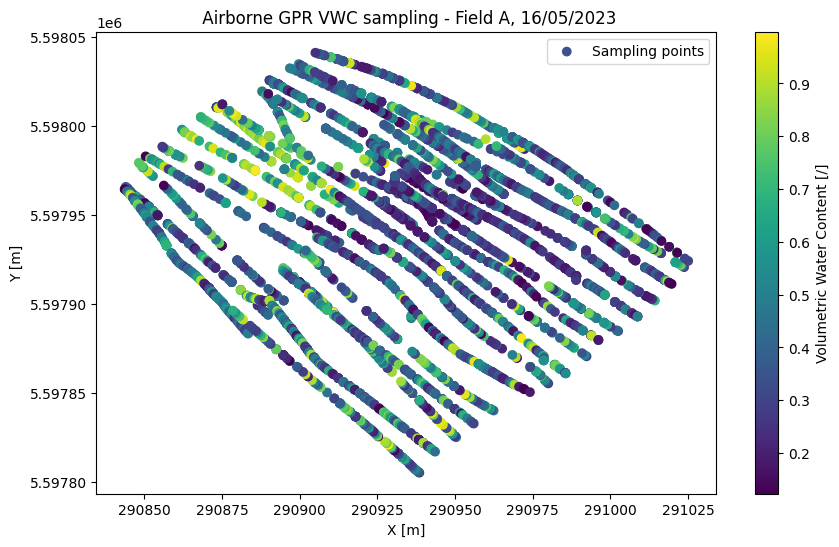

In [7]:
# Read csv file
Studied_field = import_data(field_path)[sample_number]

# Convert latitude and longitude to UTM coordinates
utm_x, utm_y = transformer.transform(Studied_field['x'].values, Studied_field['y'].values)

# Plot the sampling points
plt.figure(figsize=(10, 6))
scatter = plt.scatter(utm_x, utm_y, c=Studied_field['vwc'], cmap='viridis', label='Sampling points')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title(f' Airborne GPR VWC sampling - Field {field_letter}, {dates[sample_number]}')
cb = plt.colorbar(scatter)
cb.set_label('Volumetric Water Content [/]')
plt.grid(False)
plt.legend()
plt.show()

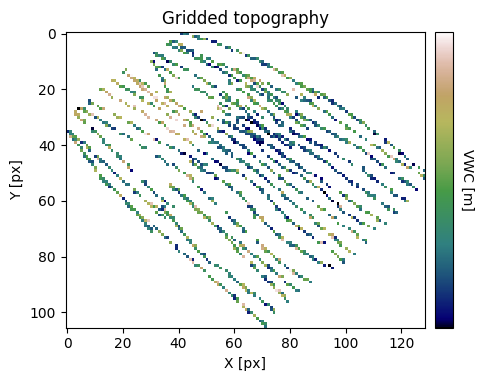

In [8]:
# grid data to 1000 m resolution
res = 0.00002  
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(Studied_field, 'x', 'y', 'vwc', res)

# plot gridded bed
fig = plt.figure(figsize = (5,5))
ax = plt.gca()
im = ax.imshow(grid_matrix, cmap='gist_earth', 
                interpolation='none', origin='upper')
plt.title('Gridded topography')
plt.xlabel('X [px]'); plt.ylabel('Y [px]')

# make color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-400, 600, 11), cax=cax)
cbar.set_label("VWC [m]", rotation=270, labelpad=15)
plt.show()


In [9]:
# remove nans
df_grid = df_grid[df_grid['Z'].isnull() == False]
df_grid.head()

,X,Y,Sum,Count,Z
71,6.052262,50.494862,1.001123,3.0,0.333708
199,6.052242,50.494882,1.492421,3.0,0.497474
200,6.052262,50.494882,0.438676,1.0,0.438676
327,6.052222,50.494902,0.887765,3.0,0.295922
328,6.052242,50.494902,0.375936,1.0,0.375936


In [10]:
# normal score transformation
data = df_grid['Z'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(data)
df_grid['Nbed'] = nst_trans.transform(data) 

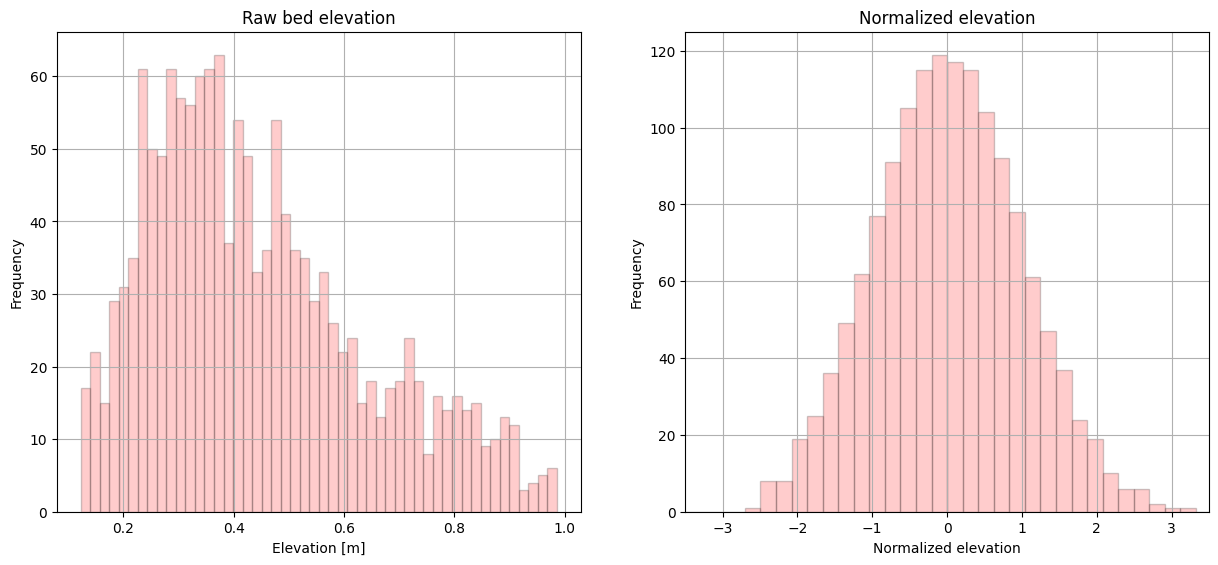

In [11]:
# plot original bed histogram
plt.subplot(121)
plt.hist(df_grid['Z'], facecolor='red', bins=50, alpha=0.2, edgecolor='black')
# plt.xlim([-700,700]); 
plt.xlabel('Elevation [m]'); plt.ylabel('Frequency'); plt.title('Raw bed elevation')
plt.grid(True)

# plot normal score bed histogram (with weights)
plt.subplot(122)
plt.hist(df_grid['Nbed'], facecolor='red', bins=50, alpha=0.2, edgecolor='black')
plt.xlim([-3.5,3.5]); 
plt.xlabel('Normalized elevation'); plt.ylabel('Frequency'); plt.title('Normalized elevation')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

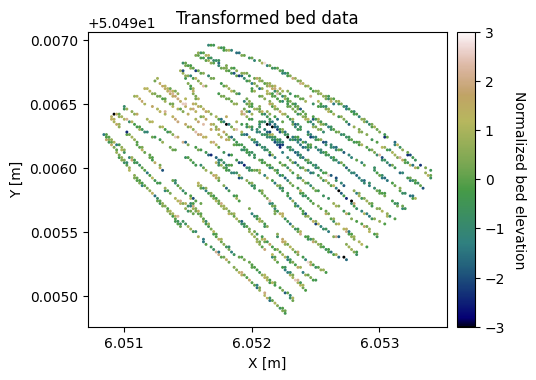

In [12]:
# plot transformed data
fig = plt.figure(figsize = (5,5))
ax = plt.gca()
im = ax.scatter(df_grid['X'], df_grid['Y'], c=df_grid['Nbed'], vmin=-3, vmax=3, 
                     marker='.', s=5, cmap='gist_earth')
plt.title('Transformed bed data')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.locator_params(nbins=5)
plt.axis('scaled')

# make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-3, 3, 7), cax=cax)
cbar.set_label("Normalized bed elevation", rotation=270, labelpad=15)
plt.show()

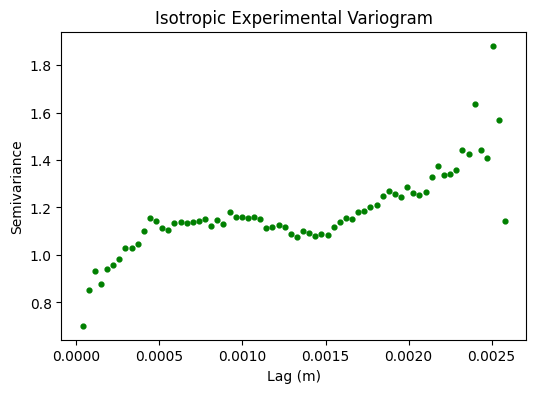

In [13]:
# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nbed']

maxlag = 10      # maximum range distance
n_lags = 70         # num of bins

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

In [14]:
# directional variogram

V0 = skg.DirectionalVariogram(coords, values, bin_func = "even", n_lags = n_lags, 
                                  maxlag = maxlag, normalize=False, azimuth=0, tolerance=15)

V45 = skg.DirectionalVariogram(coords, values, bin_func = "even", n_lags = n_lags, 
                                  maxlag = maxlag, normalize=False, azimuth=45, tolerance=15)

V90 = skg.DirectionalVariogram(coords, values, bin_func = "even", n_lags = n_lags, 
                                   maxlag = maxlag, normalize=False, azimuth=90, tolerance=15)

V135 = skg.DirectionalVariogram(coords, values, bin_func = "even", n_lags = n_lags, 
                                  maxlag = maxlag, normalize=False, azimuth=135, tolerance=15)

x0 = V0.bins
y0 = V0.experimental

x45 = V45.bins
y45 = V45.experimental

x90 = V90.bins
y90 = V90.experimental

x135 = V135.bins
y135 = V135.experimental

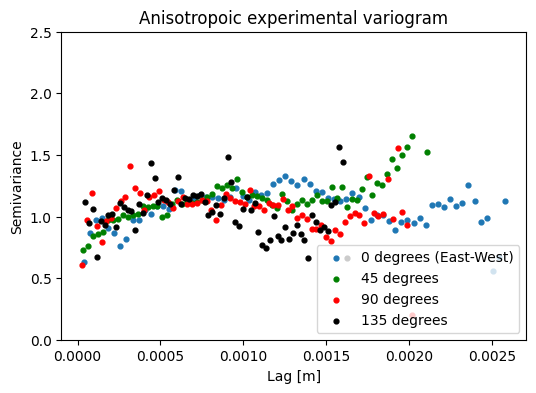

In [15]:
# plot multidirectional variogram
plt.figure(figsize=(6,4))
plt.scatter(x0, y0, s=12, label='0 degrees (East-West)')
plt.scatter(x45, y45,s=12, c='g', label='45 degrees')
plt.scatter(x90, y90, s=12, c='r', label='90 degrees')
plt.scatter(x135, y135, s=12, c='k', label='135 degrees')
plt.title('Anisotropoic experimental variogram')
plt.xlabel('Lag [m]'); plt.ylabel('Semivariance')
plt.ylim([0,2.5]); 
plt.legend(loc='lower right')
plt.show()